In [1]:
%cd ..

/home/eli/AnacondaProjects/dcpc_experiments


In [2]:
import argparse
import collections
import lightning
import numpy as np
import pyro
import torch
import logger, train

Seed set to 123


In [3]:
# pyro.enable_validation(True)
# torch.autograd.set_detect_anomaly(True)

In [4]:
config, (data, model, trainer) = train.from_file("experiments/dcpc_emnist_config.json")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [5]:
trainer.fit(model, data, ckpt_path="saved/models/EMnist_Dcpc/0612_151249/checkpoint_1999.ckpt")

Missing logger folder: saved/log/EMnist_Dcpc/0613_110306/lightning_logs
/home/eli/miniforge3/envs/dcpc/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/eli/AnacondaProjects/dcpc_experiments/saved/models/EMnist_Dcpc/0613_110306 exists and is not empty.
Restoring states from the checkpoint path at saved/models/EMnist_Dcpc/0612_151249/checkpoint_1999.ckpt
/home/eli/miniforge3/envs/dcpc/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:361: The dirpath has changed from '/home/eli/AnacondaProjects/dcpc_experiments/saved/models/EMnist_Dcpc/0612_151249' to '/home/eli/AnacondaProjects/dcpc_experiments/saved/models/EMnist_Dcpc/0613_110306', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type       | Params
-----------------------------

Sanity Checking: |                                                                                            …

`Trainer.fit` stopped: `max_epochs=2000` reached.


In [6]:
model.graph.clear()
model.eval()
model.cuda()

LightningDcpc(
  (graph): MnistDcpc(
    (prior): GaussianPrior()
    (decoder1): ConditionalGaussian(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=20, out_features=128, bias=True)
      )
    )
    (decoder2): ConditionalGaussian(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=128, out_features=256, bias=True)
      )
    )
    (likelihood): MlpBernoulliLikelihood(
      (decoder): Sequential(
        (0): ReLU()
        (1): Linear(in_features=256, out_features=784, bias=True)
      )
    )
  )
  (predictive): Predictive()
)

In [7]:
xs, _, indices = list(data.val_dataloader())[0]
xs = xs.to(model.device)
model._load_particles(indices, False)

In [8]:
posterior = {k: v['value'] for k, v in model.graph.nodes.items()}
x_hats = model.graph.predict(B=len(xs), P=model.num_particles, **posterior).mean(dim=0)

In [9]:
import matplotlib.pyplot as plt

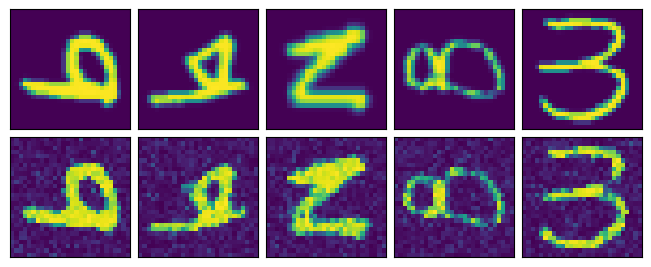

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for i in range(5):
    axes[0, i].imshow(xs[i].squeeze().detach().cpu().numpy())
    axes[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    axes[1, i].imshow(x_hats[i].squeeze().cpu().detach().numpy())
    axes[1, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("dcpc_emnist_recons.pdf", bbox_inches="tight")
plt.show()

In [11]:
del xs
del x_hats

In [12]:
model.graph.clear()

In [13]:
items = torch.randint(0, model._num_train + model._num_valid, (10,))
posterior = {k: torch.cat((v.detach(), model.particles["valid"][k].detach()), dim=1)
             for k, v in model.particles["train"].items()}
posterior = {k: v[:, items].to(device=model.device) for k, v in posterior.items()}
x_hats = model.graph.predict(B=10, P=model.num_particles, **posterior).mean(dim=0)

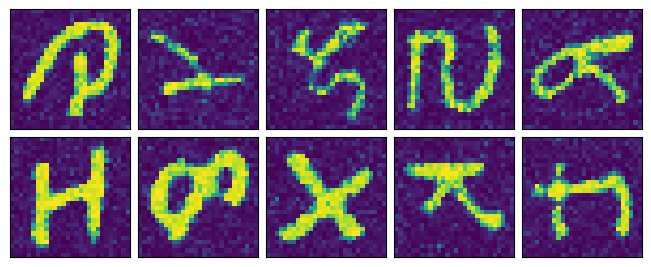

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for row in range(2):
    for col in range(5):
        axes[row, col].imshow(x_hats[row * 5 + col].squeeze().detach().cpu().numpy())
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("dcpc_emnist_predictive.pdf", bbox_inches="tight")
plt.show()

In [15]:
del x_hats

In [16]:
model.graph.clear()

In [17]:
x_hats = model.graph.predict(B=10 // model.num_particles, P=model.num_particles)
x_hats = x_hats.flatten(0, 1)

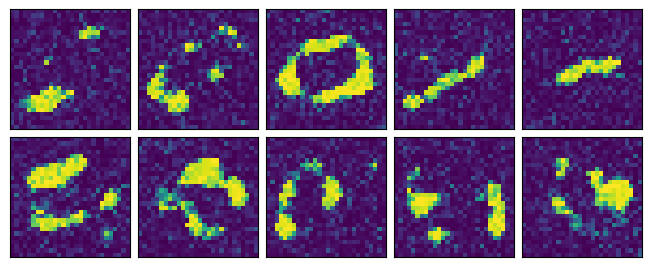

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=5, sharex="all", sharey="all", layout="compressed")

for row in range(2):
    for col in range(5):
        axes[row, col].imshow(x_hats[row * 5 + col].squeeze().detach().cpu().numpy())
        axes[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

fig.savefig("dcpc_emnist_prior.pdf", bbox_inches="tight")
plt.show()

In [19]:
del x_hats

In [20]:
model.graph.clear()

In [21]:
SEEDS = [123, 456, 789, 101112, 131415]

In [22]:
import utils

In [23]:
LOG_LIKELIHOODS = torch.zeros(len(SEEDS), model.num_particles, requires_grad=False)
MEAN_SQUARED_ERROR = torch.zeros(len(SEEDS), model.num_particles, requires_grad=False)

In [24]:
for (s, SEED) in enumerate(SEEDS):
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    for (xs, target, indices) in data.val_dataloader():
        xs = xs.to(model.device)
        model._load_particles(indices, False)
        with model.graph.condition(X=xs) as joint:
            trace, _ = joint(B=len(xs), P=model.num_particles)
        x_hats = trace.nodes["X"]["fn"].sample()
        LOG_LIKELIHOODS[s, :] += -torch.nn.functional.binary_cross_entropy(x_hats, xs.expand(*x_hats.shape), reduction="none").sum(dim=(1, 2, 3, 4)).cpu()
        MEAN_SQUARED_ERROR[s, :] += ((xs - x_hats) ** 2).mean(dim=(1, 2, 3, 4)).cpu()

    LOG_LIKELIHOODS[s] /= len(data.val_dataloader().sampler)
    MEAN_SQUARED_ERROR[s] /= len(data.val_dataloader().sampler)

In [25]:
LOG_LIKELIHOODS.mean(), LOG_LIKELIHOODS.std()

(tensor(-160.9372), tensor(0.3310))

In [26]:
MEAN_SQUARED_ERROR.mean(), MEAN_SQUARED_ERROR.std()

(tensor(3.2733e-06), tensor(2.0375e-08))